# Universal Sentence Encoder for Thida

Get sentence embeddings using the model described here: https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
!pip install --quiet tensorflow==2.0.0
!pip install --quiet tensorflow-hub
!pip install --quiet seaborn

In [ ]:
import tensorflow as tf
tf.executing_eagerly()
import tensorflow_hub as hub
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import math
import csv
import pandas as pd
from pdb import set_trace

print(tf.__version__)

2.0.0


**Mount drive**

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

root_path = '/content/drive/My Drive/Lab Stuff/'

Mounted at /content/drive


**Import data**

In [ ]:
descriptions = []
lifeline_ids = []
descr_counts = []

data_dirs =['word_analysis_e1b.csv']

for index, data in enumerate(data_dirs): 
  print(root_path + data)
  with open(root_path + data) as f: 
    csv_reader = csv.reader(f, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        descriptions.append((row[1], row[0], index))
        lifeline_ids.append(row[0])
        descr_counts.append(3)

print('lifeline ids:', lifeline_ids)
print('num lifelines:', len(lifeline_ids))
print('descr counts:', len(descriptions))

/content/drive/My Drive/Lab Stuff/word_analysis_e1b.csv
lifeline ids: ['linear_rise', 'linear_fall', 'linear_low', 'linear_middle', 'linear_high', 'exp_rise_convex', 'exp_fall_convex', 'exp_rise_concave', 'exp_fall_concave', 'sin_fr_full', 'sin_fr_partial', 'sin_rf_full', 'sin_rf_partial', 'sin_rfr_full', 'sin_rfr_partial', 'sin_frf_full', 'sin_frf_partial', 'sin_frfr', 'sin_rfrf', 'logistic_rise', 'logistic_fall', 'positive_change_full', 'positive_change_partial', 'negative_change_full', 'negative_change_partial', 'linear_rise_sharp_fall', 'linear_rise_sharp_fall_exp_rise']
num lifelines: 27
descr counts: 27


**Compute embeddings and correlations**

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/3")
descr_embeddings = embed([desc for desc, _, _ in descriptions])['outputs'].numpy()
# correlation_matrix = np.inner(descr_embeddings, descr_embeddings)
correlation_matrix = np.corrcoef(descr_embeddings)

print(descr_embeddings.shape)
print(correlation_matrix.shape)

(27, 512)
(27, 27)


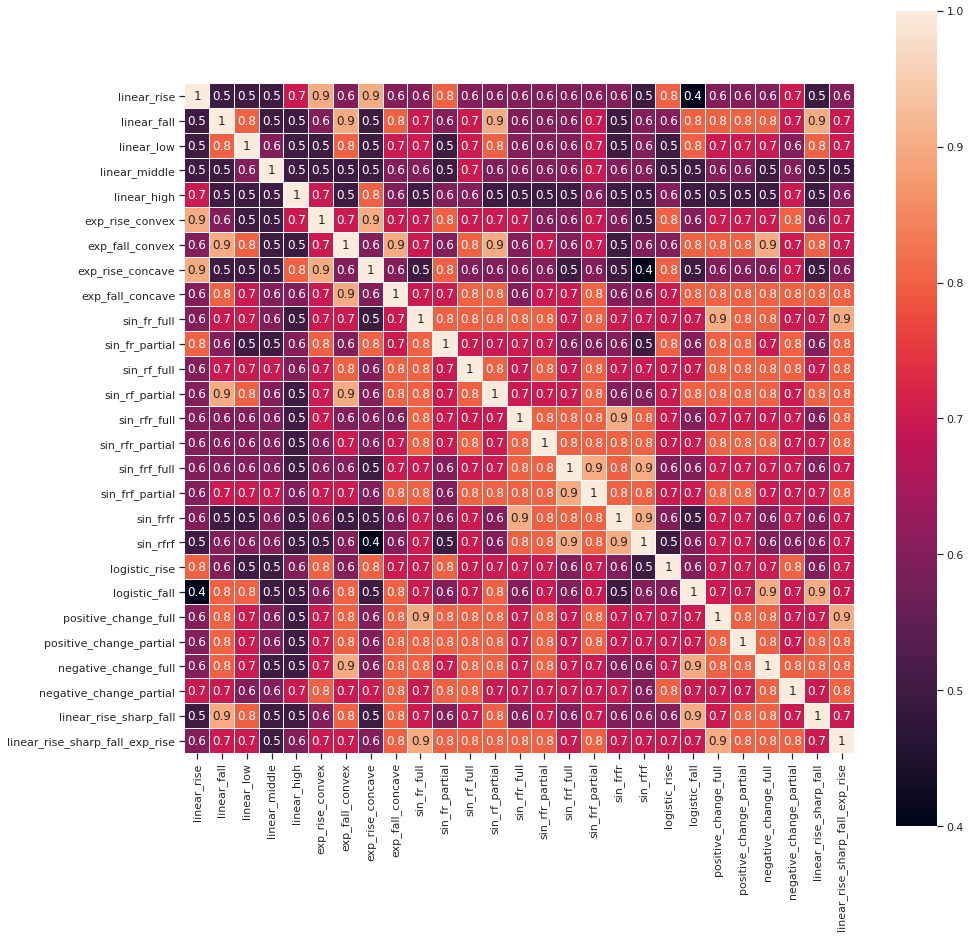

In [ ]:
#plot correlation matrix

x_axis_labels = lifeline_ids
y_axis_labels = lifeline_ids

import matplotlib.pyplot as plt
sns.set(style='ticks', color_codes=True)
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix.astype(float).round(1), 
            linewidths=0.1, 
            square=True, 
            linecolor='white', 
            annot=True,
            xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

**Download embeddings and correlations**

In [ ]:
#download embeddings
embeddings_export = pd.DataFrame(descr_embeddings)
embeddings_export.to_csv('embeddings_e1b.csv')
files.download('embeddings_e1b.csv')

#download correlations
correlations_export = pd.DataFrame(correlation_matrix)
correlations_export.to_csv('correlations_e1b.csv')
files.download('correlations_e1b.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Group same-video correlations and different-video correlations**

In [ ]:
same_vid_results = []
diff_vid_results = []
for i, (descr_1, vid_id_1, subject_1) in enumerate(descriptions):
  for j, (descr_2, vid_id_2, subject_2) in enumerate(descriptions):
    if j <= i: continue
    result = {'descr_1': descr_1,
              'vid_id_1': vid_id_1,
              'descr_2': descr_2,
              'vid_id_2': vid_id_2,
              'corr': correlation_matrix[i, j]}
    if result['vid_id_1'] == result['vid_id_2']:
      same_vid_results.append(result)
    else:
      diff_vid_results.append(result)

**Plotting helpers**

In [ ]:
def dist_compare(same_vid_scores, diff_vid_scores):
  sns.set(rc={'figure.figsize': (11.7, 8.27)})
  sns.distplot(diff_vid_scores, color='blue')
  sns.distplot([s for vid_l in list(same_vid_scores.values()) for s in vid_l], color='red')

def plot_grid(same_vid_scores, diff_vid_scores):
  fig = plt.figure()
  fig.set_size_inches(18.5*1, 10.5*1)
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i, vid_id in enumerate(vid_ids):
    scores = same_vid_scores[vid_id]

    grid_height = math.ceil(math.sqrt(len(vid_ids)))
    grid_width = math.ceil(len(vid_ids) / grid_height)
    ax = fig.add_subplot(grid_height, grid_width, i+1)
    ax.set_xlim([-0.3, 1.1])
    title = 'ID: ' + vid_id + ', # descrs: ' + str(descr_counts[i])
    sns.distplot(diff_vid_scores).set_title(title)
    custom_rug = {'color': 'r', 'alpha': 1.0, 'linewidth': 1.5, 'height': 0.6}
    sns.distplot(scores, kde=False, rug=True, hist=False, rug_kws=custom_rug)

  #plt.savefig("leyla_fig.png", dpi=150)
  #files.download("leyla_fig.png")
  plt.show()
  
def excl_noisy(scores_dict):
  noisy_vid_id = [v for i, v in enumerate(vid_ids) if descr_counts[i]==48][0]
  return {k: v for k, v in scores_dict.items() if k!= noisy_vid_id}

**Description's correlation with average same vid vs. different vid embedding**

In [ ]:
same_vid_corr_avgs_info = []

same_vid_corr_avgs = {vid_id: [] for vid_id in vid_ids}
diff_vid_corr_avgs = []
for i, (descr, vid_id, ss) in enumerate(descriptions):
  same_vid_descrs_idxs = [i for i, (d, v, s) in enumerate(descriptions)
                          if v == vid_id and d != descr]
  diff_vid_descrs_idxs = [i for i, (d, v, s) in enumerate(descriptions)
                          if v != vid_id]

  mean_same_vid_descr = np.mean(descr_embeddings[same_vid_descrs_idxs], axis=0)
  mean_diff_vid_descr = np.mean(descr_embeddings[diff_vid_descrs_idxs], axis=0)

  same_vid_corr_avg = np.correlate(descr_embeddings[i], mean_same_vid_descr)[0]
  diff_vid_corr_avg = np.correlate(descr_embeddings[i], mean_diff_vid_descr)[0]

  if not np.isnan(same_vid_corr_avg):
    same_vid_corr_avgs[vid_id].append(same_vid_corr_avg)
    same_vid_corr_avgs_info.append((vid_id, descr, list(np.array(descriptions)[same_vid_descrs_idxs]), same_vid_corr_avg))
  diff_vid_corr_avgs.append(diff_vid_corr_avg)

**Plot distributions**

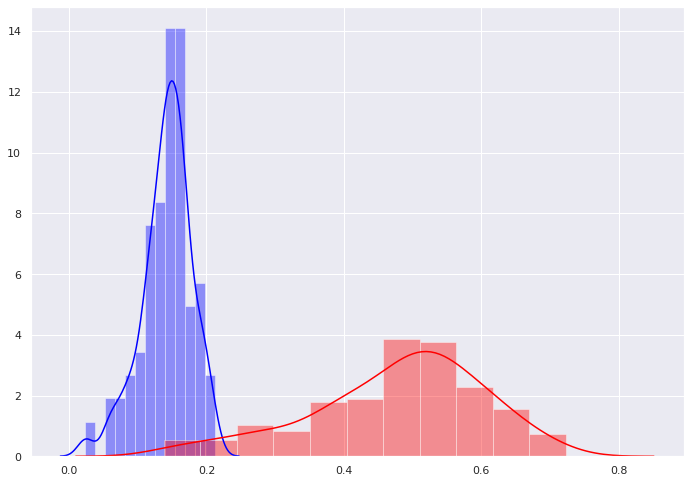

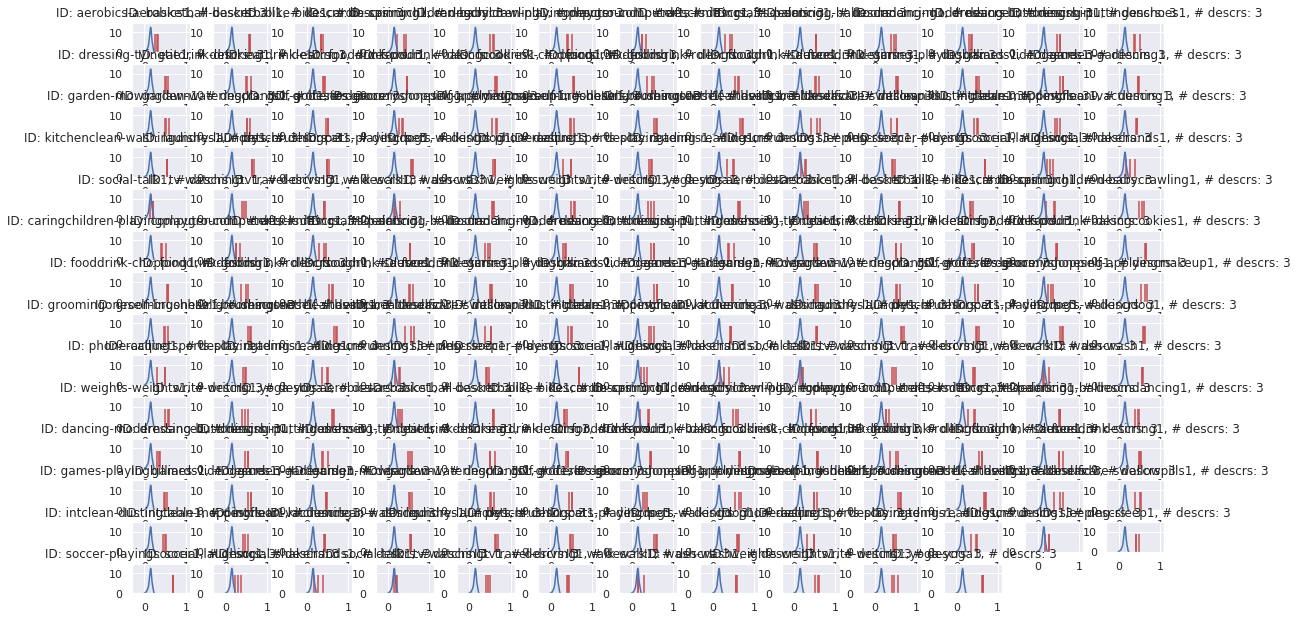

In [ ]:
dist_compare(same_vid_corr_avgs, diff_vid_corr_avgs)
plot_grid(same_vid_corr_avgs, diff_vid_corr_avgs)

**Inspect questionable cases**

In [ ]:
# metric_info = same_vid_corrs_info
# metric_info = same_vid_avgs_info
metric_info = same_vid_corr_avgs_info

threshold = 0.3 #only display descriptions with correlations lower than this value.

prev_vid_id = ''
for vid_id, item, items, score in metric_info:
  # if vid_id == vid_ids[0]: continue
  if score > threshold: continue
  if vid_id != prev_vid_id:
    descr_count = descr_counts[vid_ids.index(vid_id)]
    print('\n' + '*'*100)
    print('Video ID: {} (num descriptions: {})\n'.format(vid_id, descr_count))
    prev_vid_id = vid_id
  print('score: {}'.format(score))
  if isinstance(item, tuple):
    print('descr 1: {}'.format(item[0]))
    print('descr 2: {}\n'.format(item[1]))
  else:
    print('descr: {}\n'.format(item))
    print('the rest: {}\n'.format(items))


****************************************************************************************************
Video ID: aerobics-aerobics1 (num descriptions: 3)

score: 0.24384137988090515
descr: These women are exercising. 

the rest: [array(['Two women in a fitness studio standing in front of some potted plants are doing some leg raises very energetically. ',
       'aerobics-aerobics1', '1'], dtype='<U499'), array(['This is an exercise video where two women are demonstrating a high knees activity.  the woman in the dark blue tank top black leggings and green and gray shoes is less energetic about the activity sharing this with her hands on her hips and no clear smile.  the other woman in the light blue tank top black leggings and white and gray shoes seems much more energetic smiling waving her arms around there in a white exercise studio with two potted trees behind both are have their hair in ponytails. ',
       'aerobics-aerobics1', '2'], dtype='<U499')]


******************************